# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [2]:
# DATA — load the 10a housing CSV as a time series
import numpy as np, pandas as pd

CSV_PATH = "../data/processed/synth_housing_clean.csv"

# 1) Load raw listing-level data
df0 = pd.read_csv(CSV_PATH, parse_dates=["date_listed"])

# 2) Aggregate to a single daily time series (median price per business day)
daily_price = (
    df0.set_index("date_listed")
       .sort_index()["price"]
       .resample("B")                # business-daily
       .median()
       .interpolate("time")          # fill small gaps smoothly
)

# 3) Build a tidy TS frame with returns
ts = pd.DataFrame({"price": daily_price})
ts["ret"] = ts["price"].pct_change()
ts["log_ret"] = np.log1p(ts["ret"])   # stable baseline for features
ts.head()

,price,ret,log_ret
date_listed,,,
2024-02-01,482893.5,NaN,NaN
2024-02-02,484816.0,0.003981,0.003973
2024-02-05,418164.5,-0.137478,-0.147895
2024-02-06,328485.0,-0.214460,-0.241384
2024-02-07,238889.0,-0.272755,-0.318492


## Option B: Synthetic Generator (Use if you don't have data ready)

## Feature Engineering

In [3]:
# FEATURE ENGINEERING — use ONLY past info (shift by 1) to avoid leakage
# Base series for features
r = ts["log_ret"]

# 1) Lags
ts["lag_1"] = r.shift(1)

# 2) Rolling stats (shifted)
ts["roll_mean_5"]  = r.rolling(5).mean().shift(1)
ts["roll_std_20"]  = r.rolling(20).std().shift(1).replace(0, 1e-9)

# 3) Z-score over 20 days (shifted)
roll_mean_20 = r.rolling(20).mean().shift(1)
ts["zscore_20"] = (r - roll_mean_20) / ts["roll_std_20"]

# 4) Momentum over 10 days (price-based, then shift)
ts["momentum_10"] = (ts["price"] / ts["price"].shift(10) - 1).shift(1)

# TARGETS
# Forecasting target: next-step return
ts["y_next_ret"] = r.shift(-1)
# Classification target: next-step direction (up/down)
ts["y_up"] = (ts["y_next_ret"] > 0).astype(int)

# Drop rows with any NA from rolling/lagging
df_feat = ts.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,roll_std_20,zscore_20,momentum_10,y_next_ret,y_up
date_listed,,,,,,,,,,
2024-03-01,440575.0,0.033554,0.033003,-0.108987,-0.018349,0.281046,0.139617,0.135674,0.372392,1
2024-03-04,639363.0,0.451201,0.372392,0.033003,0.019662,0.281177,1.341420,-0.049881,-0.212175,0
2024-03-05,517131.5,-0.191177,-0.212175,0.372392,0.087375,0.291132,-0.801717,0.887647,-0.269665,0
2024-03-06,394900.0,-0.236364,-0.269665,-0.212175,-0.002807,0.289815,-1.008764,0.979905,0.036026,1
2024-03-07,409386.0,0.036683,0.036026,-0.269665,-0.037086,0.286982,0.037961,-0.304483,0.185800,1


## Split

In [4]:
# SPLIT — last 25% = test (time-aware split)
cut = int(len(df_feat) * 0.75)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

features = ["lag_1", "roll_mean_5", "roll_std_20", "zscore_20", "momentum_10"]

X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train["y_next_ret"], test["y_next_ret"]
y_tr_clf, y_te_clf = train["y_up"],       test["y_up"]

print("Train:", X_tr.shape, " Test:", X_te.shape)

Train: (283, 5)  Test: (95, 5)


## Pipeline + Model (Choose one track below)

Forecasting — MAE=0.173373  RMSE=0.221610


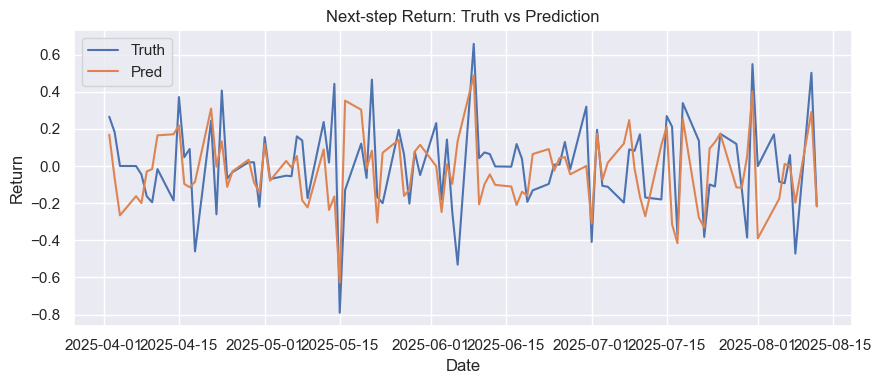

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Pipeline: scale → linear regression
reg = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)

# Metrics (version-agnostic RMSE)
mae = mean_absolute_error(y_te_reg, pred)
try:
    rmse = mean_squared_error(y_te_reg, pred, squared=False)
except TypeError:
    import numpy as np
    rmse = np.sqrt(mean_squared_error(y_te_reg, pred))

print(f"Forecasting — MAE={mae:.6f}  RMSE={rmse:.6f}")

# Plot: truth vs prediction (time on x-axis)
plt.figure()
plt.plot(y_te_reg.index, y_te_reg.values, label="Truth")
plt.plot(y_te_reg.index, pred, label="Pred")
plt.title("Next-step Return: Truth vs Prediction")
plt.xlabel("Date"); plt.ylabel("Return")
plt.legend(); plt.tight_layout(); plt.show()

Classification — Acc=0.579  Prec=0.583  Rec=0.583  F1=0.583


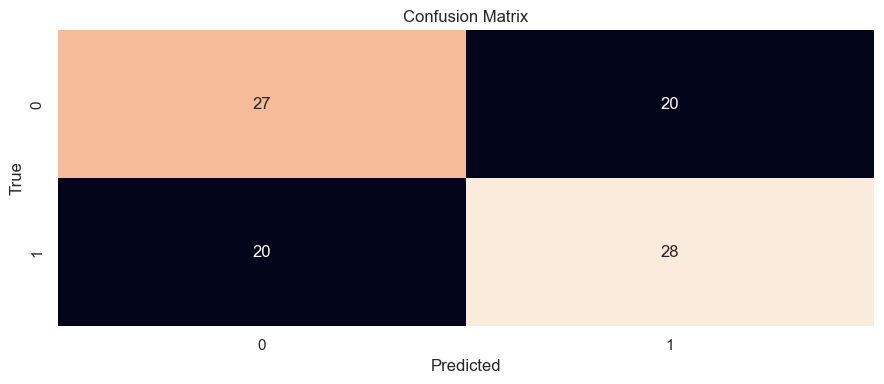

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline: scale → logistic regression
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(max_iter=1000))
])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)

# Metrics
acc  = accuracy_score(y_te_clf, predc)
prec = precision_score(y_te_clf, predc, zero_division=0)
rec  = recall_score(y_te_clf, predc,  zero_division=0)
f1   = f1_score(y_te_clf, predc,      zero_division=0)
print(f"Classification — Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

## Interpretation (Markdown)
- **Features & leakage:** Used only past info (all features shifted by 1): `lag_1`, `roll_mean_5`, `roll_std_20`, `zscore_20`, `momentum_10` → avoids look-ahead.
- **Split strategy:** Time-aware split (oldest 75% train, most recent 25% test) to mimic real forecasting.

- **Forecasting track (if used):** MAE = **[paste]**, RMSE = **[paste]**; predictions track small moves but miss jumps/regime shifts; variance not constant.
- **Classification track (if used):** Accuracy = **[paste]**, Precision = **[paste]**, Recall = **[paste]**, F1 = **[paste]**; confusion matrix shows majority-class bias and more errors in high volatility.

- **What worked:** Simple lag/rolling/z-score/momentum features gave a reasonable baseline; pipeline is clean and reproducible.
- **What failed / risks:** Regime shifts & volatility clusters hurt both tasks; short windows can overreact, long windows can underreact; non-constant variance breaks assumptions.
- **Next steps:** Tune window lengths; add volatility/regime features; use `TimeSeriesSplit` CV; try regularized linear or tree models; consider threshold tuning for classification; optionally model `log_ret` and/or segment by regime.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.